In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [358]:
import geeksw.plotting.cmsplot as plt
from libwwz import wwz_plotting
import uproot_methods

In [4]:
import libwwz
libwwz.config.year = 2018

In [5]:
import uproot
import os
import numpy as np
import pandas as pd

In [6]:
from geeksw.utils.core import concatenate
from geeksw.utils.data_loader_tools import make_data_loader, TreeWrapper, list_root_files_recursively

In [7]:
import pyarrow.parquet as pq
import pandas as pd

In [194]:
lumi = {2016 : 35.92, 2017 : 41.53, 2018 : 59.74}

In [384]:
xsec = dict(WZ=4429.7, WWZ_4l=4.12, WWZ_incl=165.1,
            TTZLOW=49.3, TTZnlo=272.8, TTZnlo_ext1=272.8, TTZnlo_ext2=272.8, TTZnlo_ext=272.8,
            ZZ=1381.6, ZZ_ext1=1381.6)

In [268]:
import json
import os

In [385]:
def analyze_dataset(year, short_name, override_path=None, scale=1.):
    if not override_path is None:
        path = override_path
    else:
        path = f"/scratch/skims/mc/{year}/{short_name}/four_lepton_skim"

        
    _dataset = pq.ParquetDataset(os.path.join(path, "parquet"))
    df_full = _dataset.read_pandas().to_pandas()
    
    df = libwwz.four_lepton_analysis.four_lepton_analysis(df_full, use_z_id_as_w_id=False)
    
    if short_name in xsec:
    
        with open(os.path.join(path, 'metainfo.json'), 'r') as myfile:
            data = myfile.read()
            full_weight_sum = json.loads(data)["genWeightSum"]
        df["weight"] = df["genWeight"] * lumi[year] * xsec[short_name] / full_weight_sum * scale
    
    return df

In [386]:
samples_info = {"wwz" : [(2016, "WWZ_incl"), # skim validated for all years
                         (2017, "WWZ_4l"),
                         (2018, "WWZ_4l")],
                "ttz" : [(2016, "TTZnlo_ext2"), # skim validated for all years
                         (2017, "TTZnlo"),
                         (2018, "TTZnlo"),
                        (2016, "TTZLOW"),
                         (2017, "TTZLOW"),
                         (2018, "TTZLOW")],
                "zz" : [(2016, "ZZ"), (2017, "ZZ"), (2018, "ZZ_ext1")],
               "wz" : [(2016, "WZ"), (2017, "WZ"), (2018, "WZ")]}

In [309]:
def analyze_sample(sample_name):
    dfs = []
    for tup in samples_info[sample_name]:
        scale = 1.
        if len(tup) == 2:
            year, short_name = tup
        else:
            year, short_name, scale = tup
        dfs.append(analyze_dataset(year, short_name, scale=scale))
    return pd.concat(dfs, ignore_index=True)

In [396]:
ls /scratch/skims/mc/2018

DY_high/      TTWnlo/  VHtoNonBB/  WZZ_incl/          ZZcontTo4tau/
DY_low/       TTWW/    WWW_2l/     ZZcontTo2e2mu/     ZZcontTo4tau_ext/
DYzpt150/     TTWZ/    WWW_incl/   ZZcontTo2e2tau/    ZZ_ext1/
GGHtoZZto4L/  TTZH/    WWZ_4l/     ZZcontTo2mu2tau/   ZZ_ext2/
TTDL/         TTZLOW/  WWZ_incl/   ZZcontTo4e/        ZZZ_4l/
TTHtoNonBB/   TTZnlo/  WZ/         ZZcontTo4e_ext1/   ZZZ_incl/
TTSL/         TTZZ/    WZG/        ZZcontTo4mu/
TTWH/         TWZ/     WZZ_4l/     ZZcontTo4mu_ext1/


In [387]:
samples = {}
samples["wwz"] = analyze_sample("wwz")

In [389]:
#samples["ttz"]

In [388]:
samples["ttz"] = analyze_sample("ttz")

In [391]:
samples["zz"] = analyze_sample("zz")

In [392]:
samples["wz"] = analyze_sample("wz")

wwz
category
BTagEMu            1.437243
EMu                8.572844
OffZ               9.092642
OnZ                1.198208
uncategorized    156.011852
Name: weight, dtype: float64

ttz
category
BTagEMu           11.479790
EMu                1.136398
OffZ              12.119847
OnZ                1.800374
uncategorized    293.885274
Name: weight, dtype: float64

zz
category
BTagEMu             1.044761
EMu                 8.796092
OffZ              159.673769
OnZ               379.072233
uncategorized    4205.856822
Name: weight, dtype: float64

wz
category
BTagEMu            0.662188
EMu                4.419024
OffZ               5.853382
OnZ                0.894913
uncategorized    117.611534
Name: weight, dtype: float32



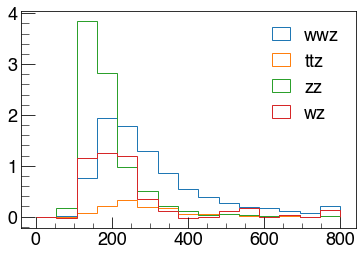

In [458]:
def clip(a):
    return np.clip(a, a_min=None, a_max=800)

bins = np.linspace(0, 800, 16)
#bins = np.linspace(0, 300, 46)

for sample_name in ["wwz", "ttz", "zz", "wz"]:
    print(sample_name)
    print(samples[sample_name].groupby("category")["weight"].sum())
    print()
    df_q = samples[sample_name].query("category == 'EMu'")
    #print(sample_name, df_q["weight"].sum())

    plt.hist(clip(df_q["veto_lepton_pt_sum"]),
    #plt.hist(clip(df_q["VetoLepton_pt_2"]),
    #plt.hist(clip(df_q["veto_lepton_pt_min"]),
             bins=bins,
             weights=np.clip(df_q["weight"], a_min=None, a_max=None),
             histtype="step",
            label=sample_name)
    
plt.legend(loc="upper right")

#plt.yscale('log', nonposy='clip')
plt.show()

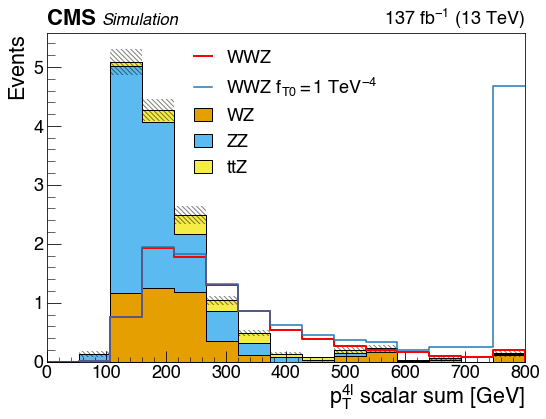

In [465]:
query = "category == 'EMu'"
#query = "not category == 'OnZ'"

wwz_plotting.wvz_hist(
    samples,
    "veto_lepton_pt_sum",
    bins,
    #query="is_ChannelEMu",
    main_background="ttz",
    plot_data=False,
    ratio_plot=False,
    xlabel=r"$p_T^{4l}$ scalar sum [GeV]",
    query=query,
    #ylim=(0,11.4),
    #log_scale=True,
)
df_q = samples["wwz"].query(query)
h = np.histogram(clip(df_q["veto_lepton_pt_sum"]), bins, weights=df_q["weight"])[0] * h_eft_scale
plt.step(bins[1:], h, label=r"WWZ $f_{T0} = 1$ TeV${}^{-4}$")
plt.legend(loc="upper center")
plt.savefig("eft_plot.pdf")
#plt.show()
#plt.ylim(0, 11)

In [208]:
#df_wz = analyze_dataset(2018, "WZ")

In [401]:
df_eft = analyze_dataset(None, None, override_path="/home/llr/cms/rembser/WWZ-leptonic-EFT-analysis/skims/2018_WWZ_dim8_four_lepton_skim")

In [459]:
def get_weigth_scales_for_ft0(df, ft0_value):
    
    x = np.array([-10, -5.0, 0, 5.0, 10])
    xx = np.linspace(-10, 10, 200)
    weights = np.zeros(len(df))
    for i, y in enumerate(df[["EFT_FT0_m10", "EFT_FT0_m5", "EFT_SM", "EFT_FT0_5", "EFT_FT0_10"]].values):
        p = np.polyfit(x, y, 2)
        weights[i] = np.polyval(p, [ft0_value])
    return weights

In [460]:
df_eft_q = df_eft.query("category == 'EMu'")

In [461]:
scale_eft = get_weigth_scales_for_ft0(df_eft_q, 5.)

In [462]:
h_sm = np.histogram(clip(df_eft_q["veto_lepton_pt_sum"]), bins, weights=df_eft_q["genWeight"])[0]
h_eft = np.histogram(clip(df_eft_q["veto_lepton_pt_sum"]), bins, weights=df_eft_q["genWeight"] * scale_eft)[0]
h_eft_scale = h_eft / h_sm

/home/llr/cms/rembser/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [212]:
def get_n_high_mass_events(ft0_value):
    mass_cut = 1200.
    query = f"category == 'EMu' and veto_lepton_pt_sum > {mass_cut}"
    #query = f"veto_lepton_pt_sum > {mass_cut}"
    if ft0_value == 0.0:
        return df_wwz_4l.query(query)["weight"].sum()
    
    df_q = df.query(query)
    weights = get_weigth_scales_for_ft0(df_q, ft0_value)
    return np.sum(weights * df_q["weight"])

In [156]:
def nll_term(s, b, n):
    return (s + b) - n * np.log(s + b)

In [175]:
ft0_vals = np.linspace(-5, 5, 50)
n_events = np.array(list(map(get_n_high_mass_events, ft0_vals)))
nll = np.array(list(map(lambda n : nll_term(0, get_n_high_mass_events(0.0), n), n_events)))

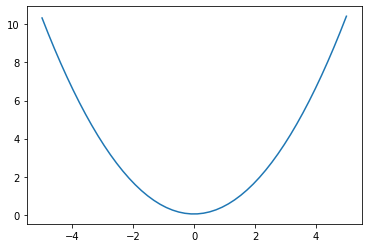

In [176]:
plt.plot(ft0_vals, nll)

In [112]:
df["EFT_FT0_0p2"] = get_weigths_for_ft0(df, 0.2)